:::{canonical-tutorial} tutorials/basics/clustering
:::

# Preprocessing and clustering

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

The data used in this basic preprocessing and clustering tutorial was collected from bone marrow mononuclear cells of healthy human donors and was part of [openproblem's NeurIPS 2021 benchmarking dataset](https://openproblems.bio/competitions/neurips_2021/) {cite}`Luecken2021`. The samples used in this tutorial were measured using the 10X Multiome Gene Expression and Chromatin Accessability kit. 


We are reading in the count matrix into an {class}`~anndata.AnnData` object, which holds many slots for annotations and different representations of the data.
See {doc}`anndata:tutorials/notebooks/getting-started` for a tutorial. 

In [3]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [4]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/home/phil/.local/share/hatch/env/virtual/scanpy-tutorials/vsyQHp6L/notebook/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/phil/.local/share/hatch/env/virtual/scanpy-tutorials/vsyQHp6L/notebook/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/home/phil/.local/share/hatch/env/virtual/scanpy-tutorials/vsyQHp6L/notebook/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/phil/.local/share/hatch/env/virtual/scanpy-tutorials/vsyQHp6L/notebook/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/phil/.local/share/hatch/env/virtual/scanpy-tutorials/vsyQHp6L/notebook/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

The data contains ~8,000 cells per sample and 36,601 measured genes. We'll now investigate these with a basic preprocessing and clustering workflow.

## Quality Control

The scanpy function {func}`~scanpy.pp.calculate_qc_metrics` calculates common quality control (QC) metrics, which are largely based on `calculateQCMetrics` from scater {cite}`McCarthy2017`. One can pass specific gene population to {func}`~scanpy.pp.calculate_qc_metrics` in order to calculate proportions of counts for these populations. Mitochondrial, ribosomal and hemoglobin genes are defined by distinct prefixes as listed below. 

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

One can now inspect violin plots of some of the computed QC metrics:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

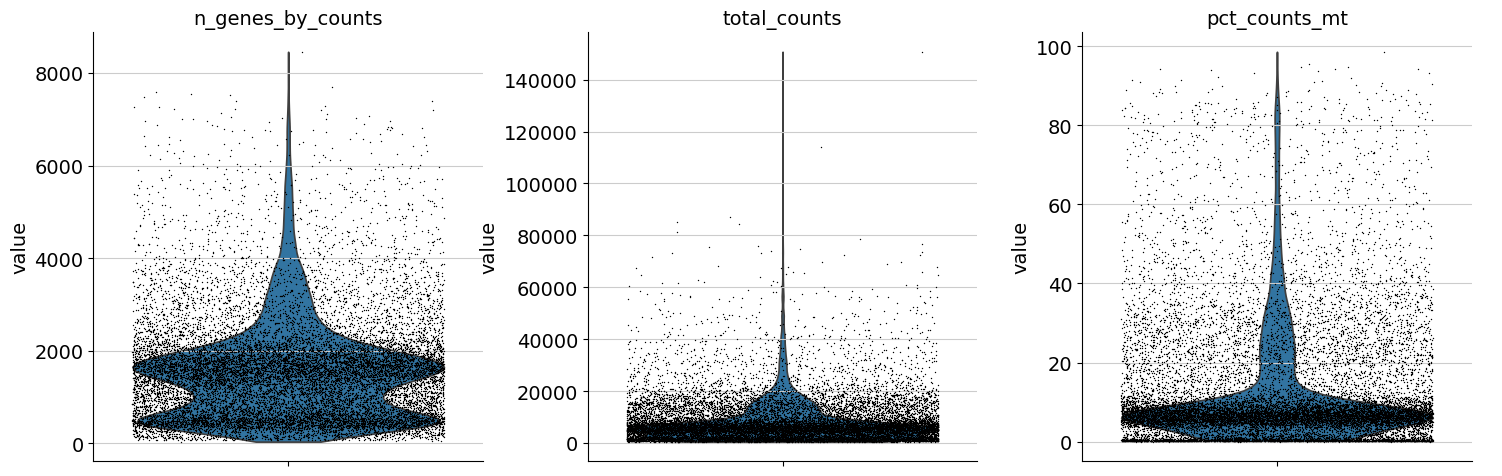

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Additionally, it is useful to consider QC metrics jointly by inspecting a scatter plot colored by `pct_counts_mt`. 

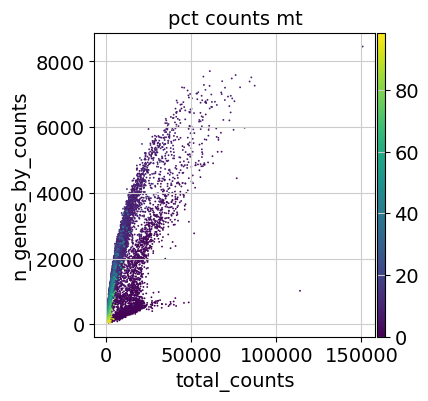

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Based on the QC metric plots, one could now remove cells that have too many mitochondrial genes expressed or too many total counts by setting manual or automatic thresholds. However, sometimes what appears to be poor QC metrics can be driven by real biology so we suggest starting with a very permissive filtering strategy and revisiting it at a later point. We therefore now only filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells. 

Additionally, it is important to note that for datasets with multiple batches, quality control should be performed for each sample individually as quality control thresholds can vary substantially between batches. 

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

### Doublet detection

As a next step, we run a doublet detection algorithm. Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scanpy contains the doublet detection method Scrublet {cite}`Wolock2019`. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. {func}`scanpy.pp.scrublet` adds `doublet_score` and `predicted_doublet` to `.obs`. One can now either filter directly on `predicted_doublet` or use the `doublet_score` later during clustering to filter clusters with high doublet scores. 

In [10]:
sc.pp.scrublet(adata, batch_key="sample")

We can remove doublets by either filtering out the cells called as doublets, or waiting until we've done a clustering pass and filtering out any clusters with high doublet scores.

:::{seealso}
Alternative methods for doublet detection within the scverse ecosystem are [DoubletDetection](https://github.com/JonathanShor/DoubletDetection) and [SOLO](https://docs.scvi-tools.org/en/stable/user_guide/models/solo.html). You can read more about these in the [Doublet Detection chapter](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#doublet-detection) of Single Cell Best Practices.
:::

## Normalization

The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via `target_sum` in `pp.normalize_total`. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [11]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [12]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function `pp.highly_variable_genes` annotates highly variable genes by reproducing the implementations of Seurat {cite}`Satija2015`, Cell Ranger {cite}`Zheng2017`, and Seurat v3 {cite}`Stuart2019` depending on the chosen `flavor`. 

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

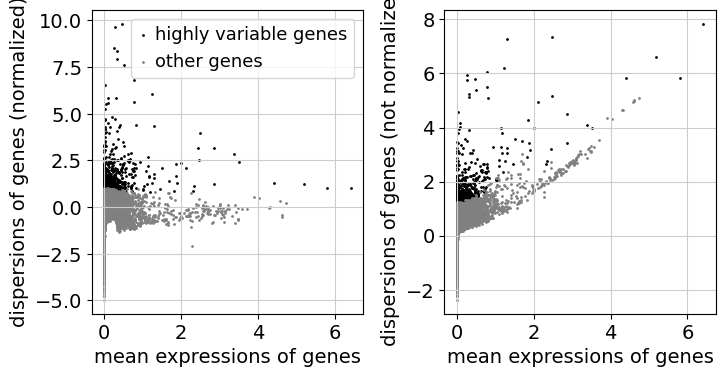

In [14]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [15]:
sc.tl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function {func}`~scanpy.tl.leiden` or {func}`~scanpy.tl.tsne`. In our experience, there does not seem to be signifigant downside to overestimating the numer of principal components.

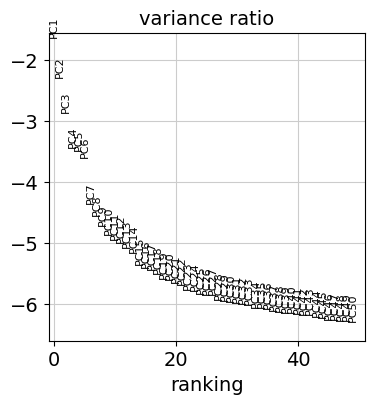

In [16]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

You can also plot the principal components to see if there are any potentially undesired features (e.g. batch, QC metrics) driving signifigant variation in this dataset. In this case, there isn't anything too alarming, but it's a good idea to explore this.

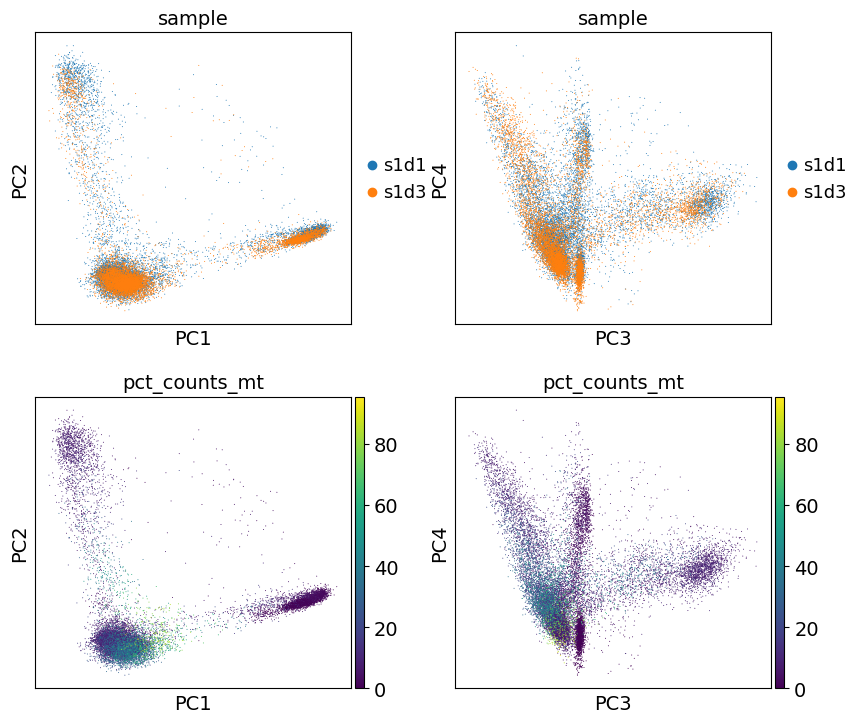

In [17]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Nearest neighbor graph constuction and visualization

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.

In [18]:
sc.pp.neighbors(adata)

This graph can then be embedded in two dimensions for visualiztion with UMAP {cite:p}`McInnes2018`:

In [19]:
sc.tl.umap(adata)

We can now visualize the UMAP according to the `sample`. 

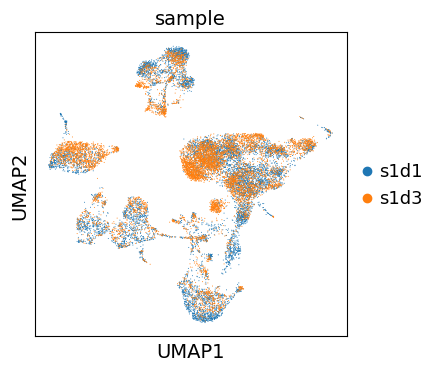

In [20]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

Even though the data considered in this tutorial includes two different samples, we only observe a minor batch effect and we can continue with clustering and annotation of our data. 

If you inspect batch effects in your UMAP it can be beneficial to integrate across samples and perform batch correction/integration. We recommend checking out [`scanorama`](https://github.com/brianhie/scanorama) and [`scvi-tools`](https://scvi-tools.org) for batch integration.

## Clustering

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) {cite}`Traag2019`. Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [21]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

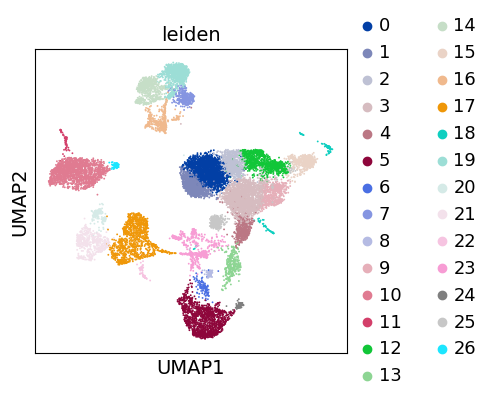

In [22]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering 

As indicated before, we will now re-assess our filtering strategy by visualizing different QC metrics using UMAP. 

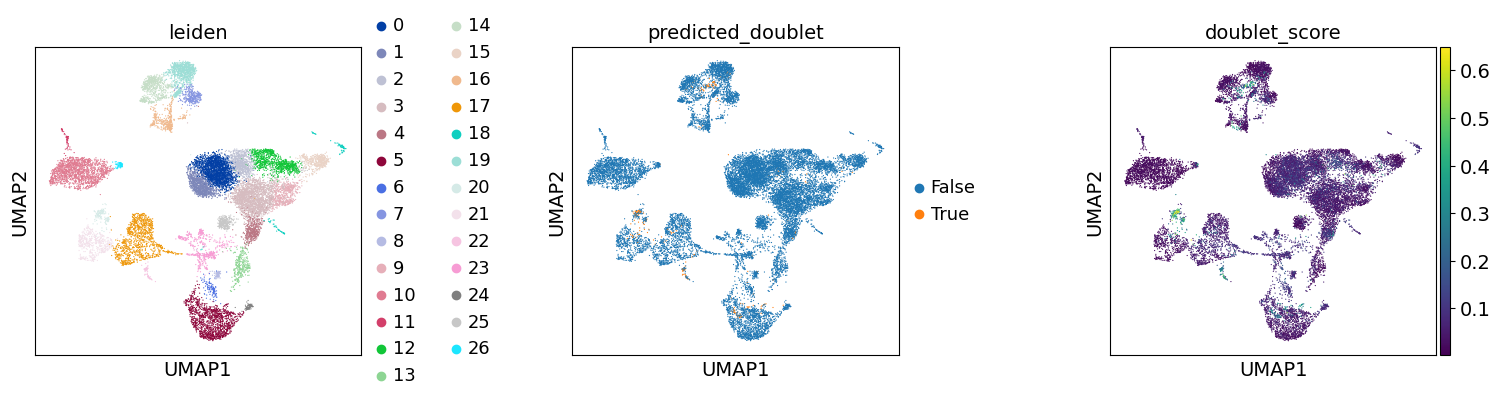

In [23]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

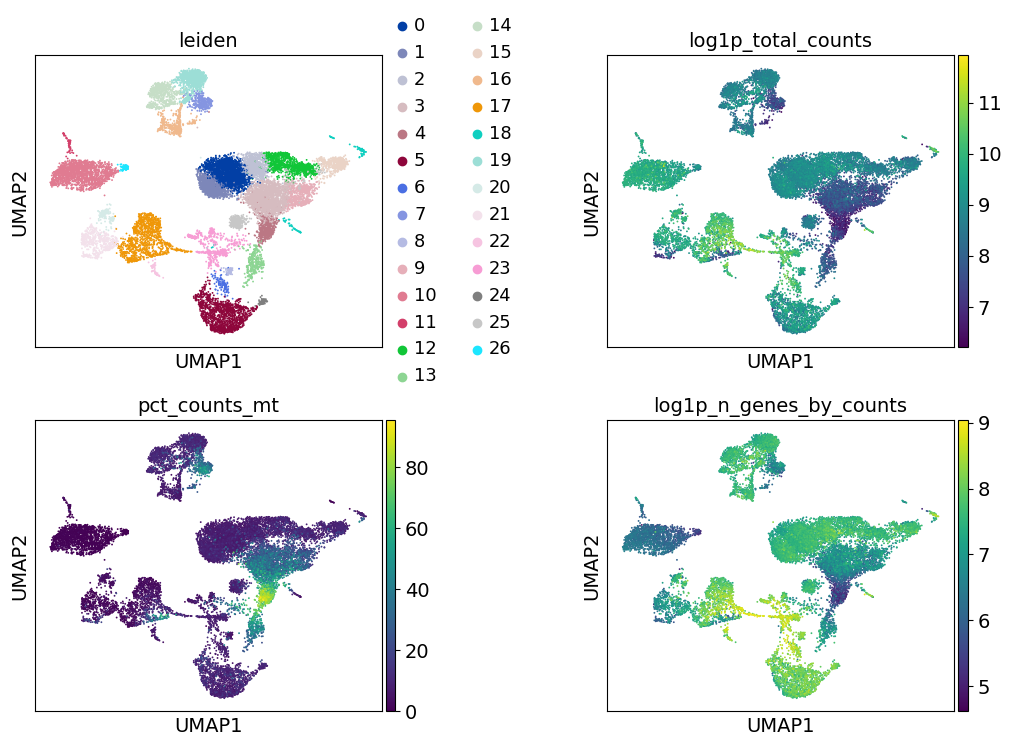

In [24]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

## Manual cell-type annotation

:::{note}
This section of the tutorial is expanded upon using prior knowledge resources like automated assignment and gene enrichment in the scverse tutorial [here](https://scverse-tutorials.readthedocs.io/en/latest/notebooks/basic-scrna-tutorial.html#cell-type-annotation)
:::

Cell type annotation is laborous and repetitive task, one which typically requires multiple rounds of subclustering and re-annotation. It's difficult to show the entirety of the process in this tutorial, but we aim to show how the tools scanpy provides assist in this process.

We have now reached a point where we have obtained a set of cells with decent quality, and we can proceed to their annotation to known cell types. Typically, this is done using genes that are exclusively expressed by a given cell type, or in other words these genes are the marker genes of the cell types, and are thus used to distinguish the heterogeneous groups of cells in our data. Previous efforts have collected and curated various marker genes into available resources, such as [CellMarker](http://bio-bigdata.hrbmu.edu.cn/CellMarker/), [TF-Marker](http://bio.liclab.net/TF-Marker/), and [PanglaoDB](https://panglaodb.se/). The [cellxgene gene expression tool](https://cellxgene.cziscience.com/gene-expression) can also be quite useful to see which cell types a gene has been expressed in across many existing datasets.

Commonly and classically, cell type annotation uses those marker genes subsequent to the grouping of the cells into clusters. So, let's generate a set of clustering solutions which we can then use to annotate our cell types. Here, we will use the Leiden clustering algorithm which will extract cell communities from our nearest neighbours graph.

In [25]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

Notably, the number of clusters that we define is largely arbitrary, and so is the `resolution` parameter that we use to control for it. As such, the number of clusters is ultimately bound to the stable and biologically-meaningful groups that we can ultimately distringuish, typically done by experts in the corresponding field or by using expert-curated prior knowledge in the form of markers.

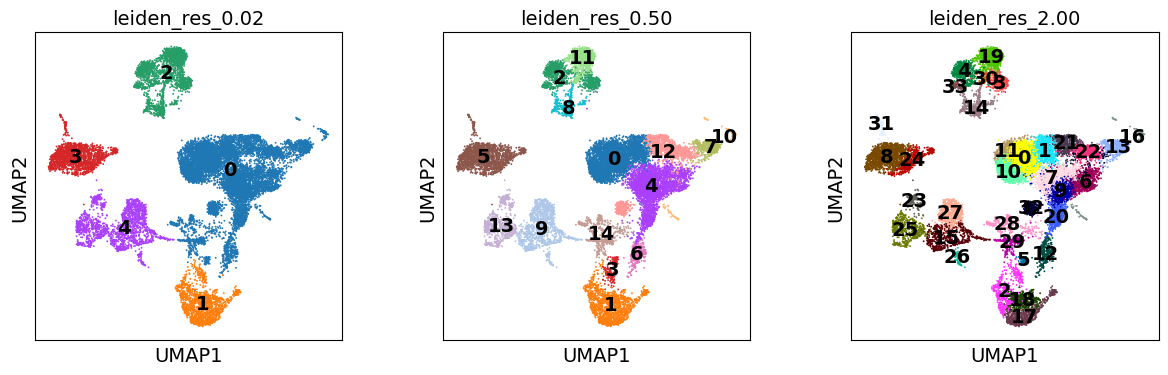

In [26]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

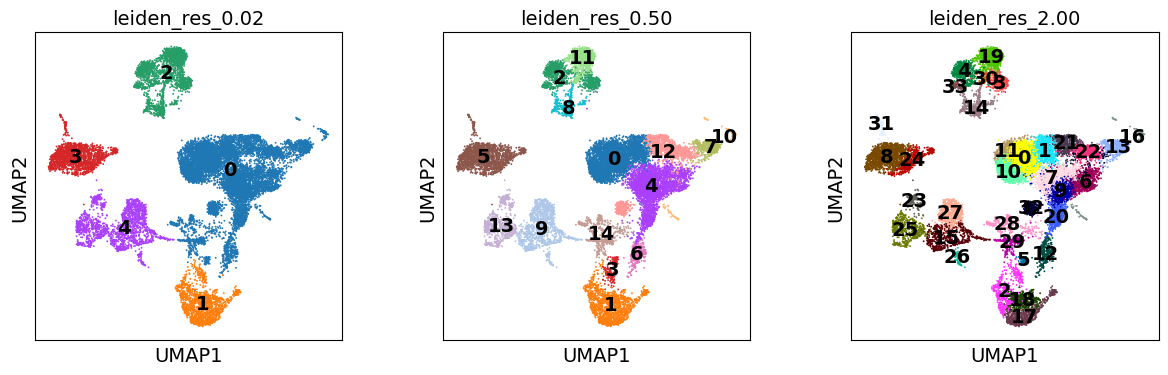

In [27]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

Though UMAPs should not be over-interpreted, here we can already see that in the highest resolution our data is over-clustered, while the lowest resolution is likely grouping cells which belong to distinct cell identities.

### Marker gene set

Let's define a set of marker genes for the main cell types that we expect to see in this dataset. These were adapted from [Single Cell Best Practices annotation chapter](https://www.sc-best-practices.org/cellular_structure/annotation.html), for a more detailed overview and best practices in cell type annotation, we refer the user to it.

In [28]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

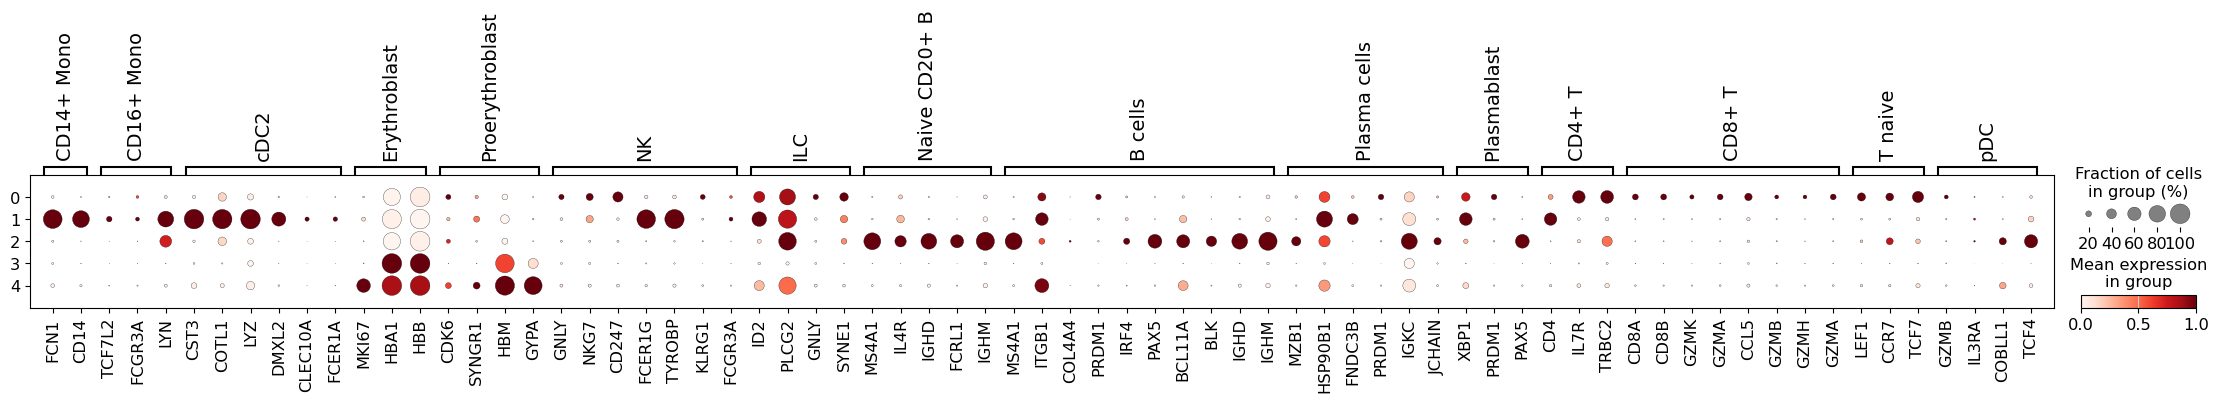

In [29]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

There are fairly clear patterns of expression for our markers show here, which we can use to label our coarsest clustering with broad lineages.

In [30]:
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
    }
)

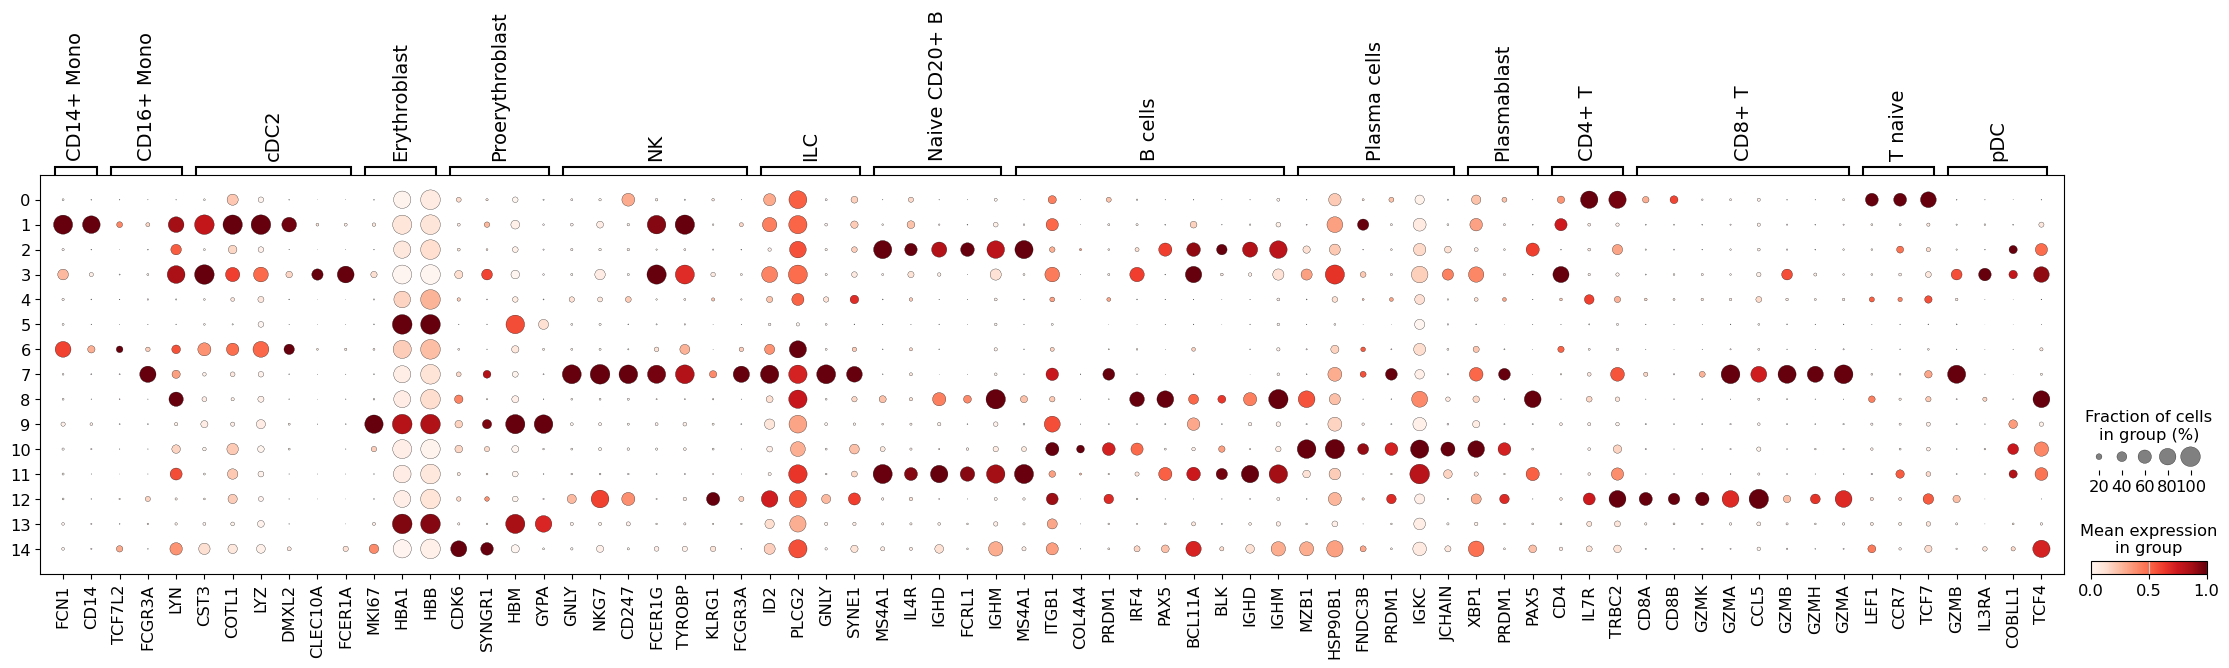

In [31]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

This seems like a resolution that suitable to distinguish most of the different cell types in our data. As such, let's try to annotate those by manually using the dotplot above, together with the UMAP of our clusters. Ideally, one would also look specifically into each cluster, and attempt to subcluster those if required.

### Differentially-expressed Genes as Markers

Furthermore, one can also calculate marker genes per cluster and then look up whether we can link those marker genes to any known biology, such as cell types and/or states. This is typically done using simple statistical tests, such as Wilcoxon and t-test, for each cluster vs the rest.

In [32]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

We can then visualize the top 5 differentially-expressed genes on a dotplot.

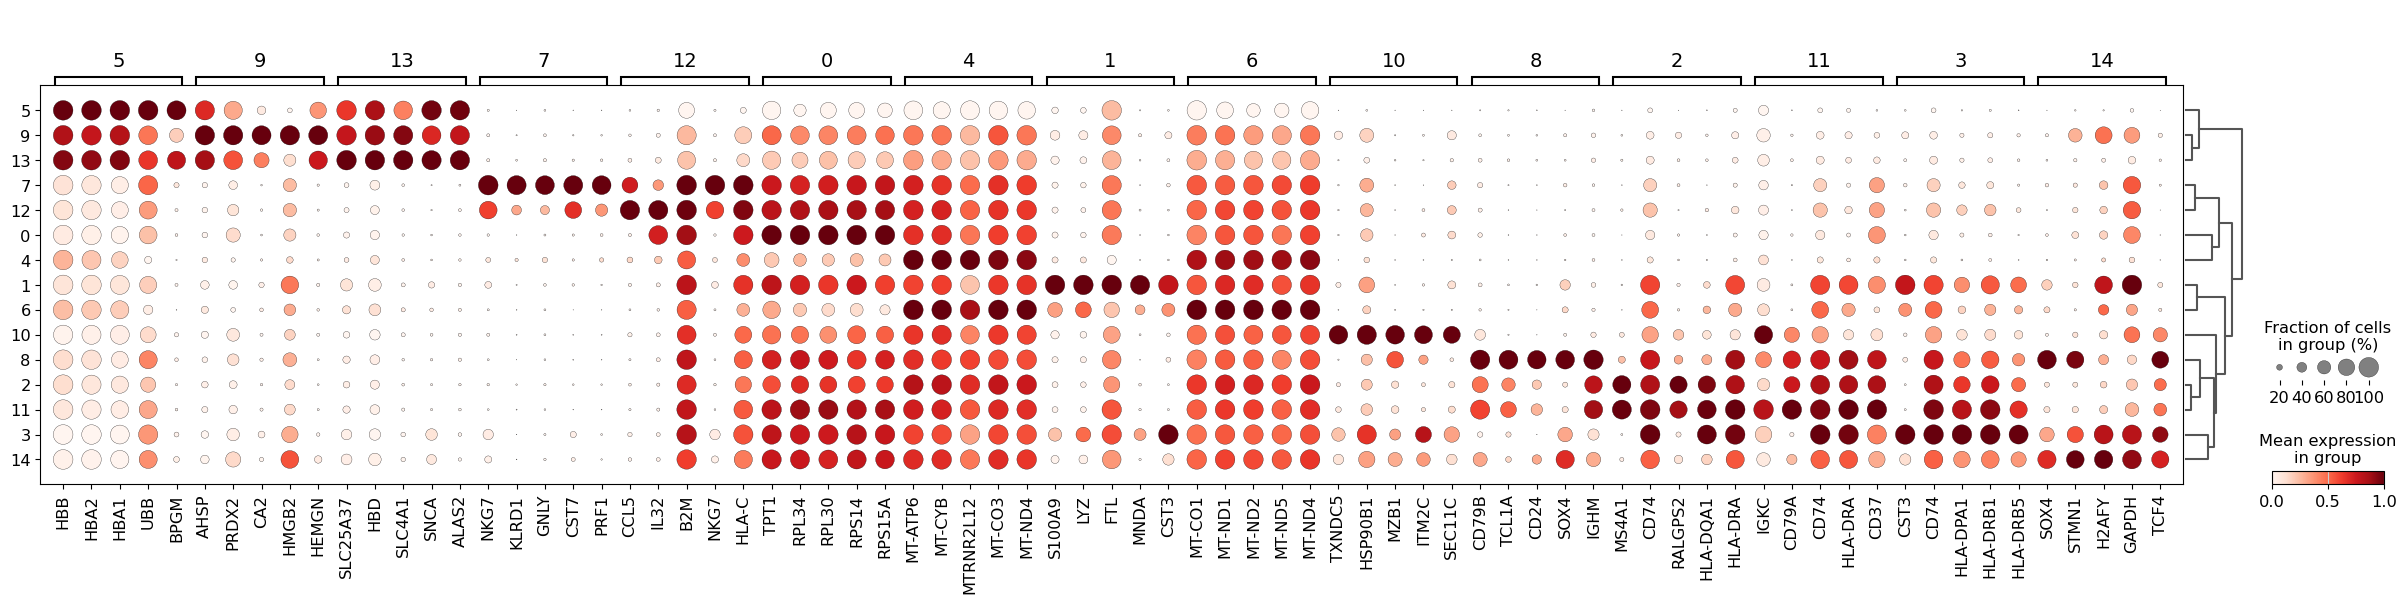

In [33]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

We can then use these genes to figure out what cell types we're looking at. For example, Cluster 7 is expressing [*NKG7*](https://www.genecards.org/cgi-bin/carddisp.pl?gene=NKG7&keywords=nkg7) and [*GNLY*](https://www.genecards.org/cgi-bin/carddisp.pl?gene=GNLY&keywords=GNLY), suggesting these are [NK cells](https://en.wikipedia.org/wiki/Natural_killer_cell).

To create your own plots, or use a more automated approach, the differentially expressed genes can be extracted in a convenient format with {func}`scanpy.get.rank_genes_groups_df`

In [34]:
sc.get.rank_genes_groups_df(adata, group="7").head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,NKG7,35.376785,6.544684,3.885326e-274,9.102153e-270
1,KLRD1,33.815022,5.840619,1.186288e-250,1.389558e-246
2,GNLY,33.775005,7.383827,4.592379e-250,3.586189e-246
3,CST7,33.003643,5.238780,7.201598e-239,4.217796e-235
4,PRF1,32.752277,5.397196,2.817787e-235,1.320246e-231


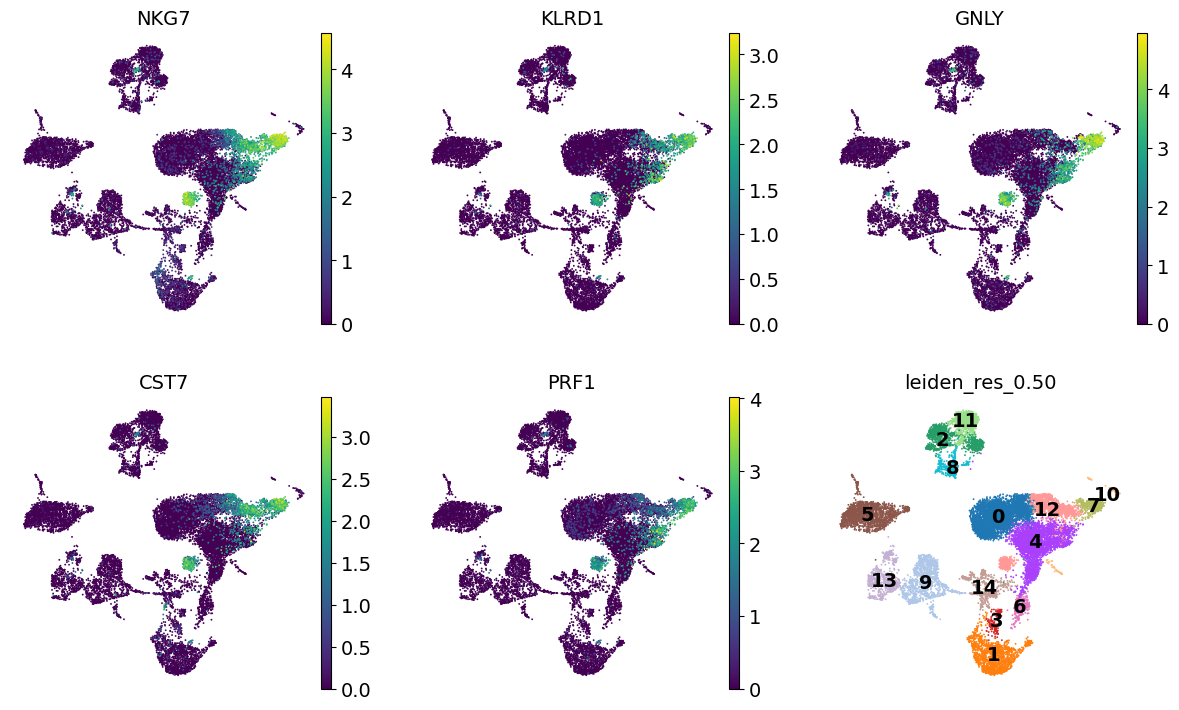

In [35]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

You may have noticed that the p-values found here are extremely low. This is due to the statistical test being performed considering each cell as an independent sample. For a more conservative approach you may want to consider "pseudo-bulking" your data by sample (*e.g.* `sc.get.aggregate(adata, by=["sample", "cell_type"], func="sum", layer="counts")`) and using a more powerful differential expression tool, like [`pydeseq2`](https://pydeseq2.readthedocs.io/).